In [72]:
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

from typing import List, Dict
from gretel_client import configure_session

In [73]:
# Specify your Gretel API key

pd.set_option("max_colwidth", None)

configure_session(api_key='grtu9cd34f3901cfac9e13f08002d42705fcbb214dca7a7731179c6a318cb2af2e0a', cache="yes", validate=True)


Using endpoint https://api.gretel.cloud
Logged in as hoang.nd@orai.io ✅


In [74]:
# Load timeseries example to a dataframe

data_source = "./AAPL Historical Data.csv"
original_df = pd.read_csv(data_source)
original_df.to_csv("original.csv", index=False)
original_df


,Date,Price
0,11/01/2013,19.86
1,12/01/2013,20.04
2,01/01/2014,17.88
3,02/01/2014,18.79
4,03/01/2014,19.17
...,...,...
94,09/01/2021,141.50
95,10/01/2021,149.80
96,11/01/2021,165.30
97,12/01/2021,177.57


In [75]:
# Gretel Transforms Configuration
config = """
schema_version: "1.0"
models:
    - transforms:
        data_source: "__tmp__"
        policies:
            - name: shiftnumbers
              rules:
                - name: shiftnumbers
                  conditions:
                    field_name:
                        - Price
                  transforms:
                    - type: numbershift
                      attrs:
                        min: 1
                        max: 100
                        field_name:
                            - Date
              
"""


In [76]:
# De-identify the original dataset using the policy above
import yaml

from gretel_client.projects import create_or_get_unique_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_or_get_unique_project(name="numbershift-transform")

model = project.create_model_obj(
    model_config=yaml.safe_load(config), data_source=data_source
)

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

record_handler = model.create_record_handler_obj(data_source=data_source)
record_handler.submit_cloud()
poll(record_handler)

deid_df = pd.read_csv(record_handler.get_artifact_link("data"), compression="gzip")


KeyboardInterrupt: 

In [ ]:
# Here we sort and remove "net_amt" as it's a derived column,
# We will add back in after the data is synthesized
train_df = deid_df.copy()

train_df.sort_values("Date", inplace=True)
train_cols = list(train_df.columns)
train_df = train_df.filter(train_cols)

# Here we noticed that some number have extremely long precision,
# so we round the data
train_df = train_df.round(1)
train_df.to_csv("train.csv", index=False)
train_df


,Date,Price
2,01/01/2014,49.9
14,01/01/2015,97.3
26,01/01/2016,57.3
38,01/01/2017,32.3
50,01/01/2018,82.9
...,...,...
49,12/01/2017,124.3
61,12/01/2018,90.4
73,12/01/2019,82.4
85,12/01/2020,180.7


In [ ]:
from gretel_client.projects.models import read_model_config

# Create a project and model configuration.
project = create_or_get_unique_project(name="ts-5544-regular-seed")

# Pull down the default synthetic config.  We will modify it slightly.
config = read_model_config("synthetics/default")

# Set up the seed fields
seed_fields = ["Date"]

task = {
    "type": "seed",
    "attrs": {
        "fields": seed_fields,
    },
}

# Fine tune model parameters. These are the parameters we found to work best.  This is "Run 20" in the document
config['models'][0]['synthetics']['task'] = task
 
config['models'][0]['synthetics']['params']['vocab_size'] = 20
config['models'][0]['synthetics']['params']['learning_rate'] = 0.001
config['models'][0]['synthetics']['params']['epochs'] = 500
config['models'][0]['synthetics']['params']['dropout_rate'] = 0.001
config['models'][0]['synthetics']['params']['gen_temp'] = .8
config['models'][0]['synthetics']['generate']['num_records'] = train_df.shape[0]

# Get a csv to work with, just dump out the train_df.
deid_df.to_csv("train.csv", index=False)

# Initiate a new model with the chosen config
model = project.create_model_obj(model_config=config, data_source="train.csv")

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

synthetic = pd.read_csv(model.get_artifact_link("data_preview"), compression="gzip")
synthetic


INFO: Starting poller


{
    "uid": "63439bc37ec6f5c388b04922",
    "guid": "model_2Fvamg33eI3f9hvsLddNGRvoznO",
    "model_name": "default-config",
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633fff1f44a4f15b630a3529",
    "project_guid": "proj_2Fnr0BIix7lRhD3Z2BF0BFNT0b7",
    "status_history": {
        "created": "2022-10-10T04:12:51.543491Z"
    },
    "last_modified": "2022-10-10T04:12:51.749057Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:3339cda15d1ac57a84a12275267fe2f59cf27b43e00b916e8f4f154b5e8398a1",
    "container_image_version": "2.10.0",
    "model_type": "synthetics",
    "config": {
        "schema_version": "

INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2022-10-10T04:13:12.044791Z  Starting synthetic model training
2022-10-10T04:13:12.047909Z  Loading training data
2022-10-10T04:13:12.183753Z  Running pre-flight data checks on input data
2022-10-10T04:13:12.224726Z  We found 1 warning. If your model fails, try modifying the fields or adjusting your configuration settings.

	1 field with high floating point precision: 'Price' has floats with precision greater than 6 digits. Try reducing precision to 4 digits.
2022-10-10T04:13:12.239460Z  Training data loaded
{
    "record_count": 99,
    "field_count": 2,
    "upsample_count": 9901
}
2022-10-10T04:13:15.063658Z  Creating semantic validators and preparing training data
2022-10-10T04:13:16.074672Z  Beginning ML model training
2022-10-10T04:13:16.075155Z  Running training on 1 batches.
{
    "batch_sizes": "[2]"
}
2022-10-10T04:13:16.

,Date,Price
0,11/01/2013,43.12
1,12/01/2013,113.04
2,11/01/2014,49.88
3,12/01/2014,108.79
4,11/01/2015,72.88
...,...,...
94,08/01/2019,90.19
95,06/01/2015,131.36
96,11/01/2019,165.81
97,02/01/2018,81.53


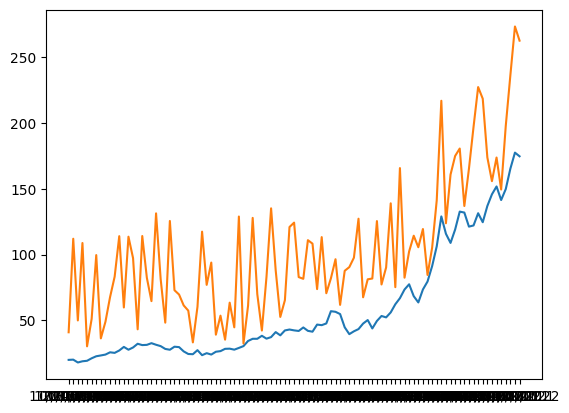

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


data = pd.read_csv('./original.csv')
data_new = pd.read_csv('./train.csv')
plt.plot(data['Date'],data['Price'],data_new['Date'],data_new['Price'])

